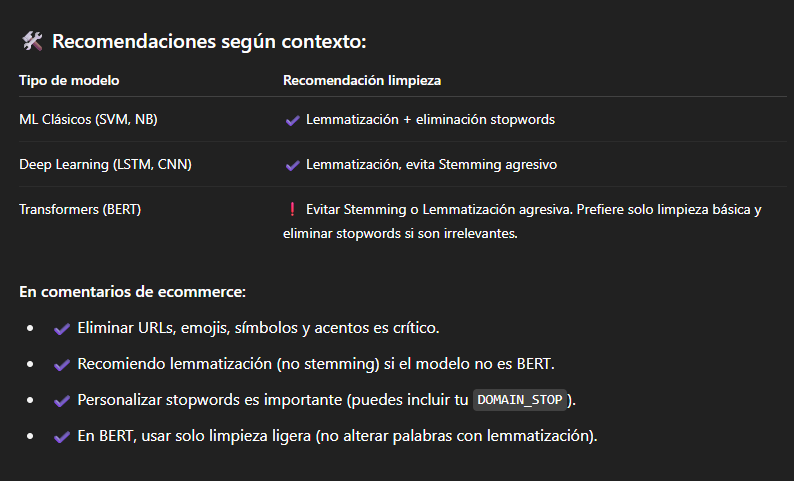

In [24]:
# ------------------ Librerías necesarias ------------------
import pandas as pd
import re
import html
import unicodedata
import spacy
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import nltk

In [25]:
# Descargamos recursos de NLTK si no están previamente descargados.
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aluca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aluca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
# ------------------ Función limpieza con NLTK + regex ------------------
def clean_text_nltk(text,
                    language='spanish',
                    use_lemmatize=True,
                    custom_stopwords=None,
                    custom_words_remove=None):
    """
    Limpia texto usando regex + NLTK, con opción de lemmatización o stemming.
    
    Parámetros:
    - text: Texto original.
    - language: Idioma para stopwords y stemmer.
    - use_lemmatize: Si True aplica lemmatización, si False aplica stemming.
    - custom_stopwords: set de palabras personalizadas adicionales a eliminar (se suman a las stopwords estándar).
    - custom_words_remove: lista de palabras específicas que quieras eliminar aunque no sean stopwords.

    Retorna:
    - Texto limpio como string.
    """
    # Cargar stopwords estándar de NLTK
    stop_words = set(stopwords.words(language))
    
    # Agregar stopwords personalizadas si se pasan como parámetro
    if custom_stopwords:
        stop_words |= set(custom_stopwords)
        
    # Inicializar lemmatizer y stemmer
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language)

    # Proceso básico de limpieza
    text = html.unescape(str(text))
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenización simple
    words = text.split()
    
    # Filtrar stopwords + palabras manuales
    words = [w for w in words if w not in stop_words and (custom_words_remove is None or w not in custom_words_remove)]
    
    # Lemmatización o Stemming según parámetro
    if use_lemmatize:
        words = [lemmatizer.lemmatize(w) for w in words]
    else:
        words = [stemmer.stem(w) for w in words]

    return ' '.join(words)

In [27]:
# ------------------ Función limpieza con spaCy ------------------
def clean_text_spacy(text,
                    nlp_model=None,
                    use_lemmatize=True,
                    custom_stopwords=None,
                    custom_words_remove=None):
    """
    Limpia texto usando spaCy, con opción de lemmatización (spaCy) o stemming (NLTK).
    
    Parámetros:
    - text: Texto original.
    - nlp_model: Modelo spaCy cargado previamente.
    - use_lemmatize: Si True usa lemmatización, si False aplica stemming con NLTK.
    - custom_stopwords: set de palabras personalizadas adicionales a eliminar.
    - custom_words_remove: lista de palabras específicas a eliminar.

    Retorna:
    - Texto limpio como string.
    """
    stemmer = SnowballStemmer('spanish')
    
    # Cargar modelo si no se pasa uno ya cargado (opcional para eficiencia)
    if nlp_model is None:
        nlp_model = spacy.load("es_core_news_sm", disable=['ner', 'parser'])

    # Proceso básico de limpieza
    text = html.unescape(str(text))
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text).strip()

    # Procesamiento con spaCy (tokenización inteligente)
    doc = nlp_model(text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space or token.like_num:
            continue
        if custom_stopwords and token.text in custom_stopwords:
            continue
        if custom_words_remove and token.text in custom_words_remove:
            continue

        if use_lemmatize:
            tokens.append(token.lemma_)
        else:
            tokens.append(stemmer.stem(token.text))
    
    return ' '.join(tokens)

In [28]:
# ------------------ Wrapper general para DataFrame ------------------
def aplicar_limpieza_texto(df, 
                        columna_texto='comentarios',
                        metodo='nltk',
                        use_lemmatize=True,
                        custom_stopwords=None,
                        custom_words_remove=None):
    """
    Aplica la limpieza elegida a la columna de texto en el DataFrame.
    
    Crea una nueva columna según el método usado.
    """
    if columna_texto not in df.columns:
        raise ValueError(f"La columna '{columna_texto}' no existe en el DataFrame.")
    
    df[columna_texto] = df[columna_texto].fillna('')
    
    if metodo == 'nltk':
        df['comentarios_limpios_nltk'] = df[columna_texto].apply(
            lambda x: clean_text_nltk(x,
                                    use_lemmatize=use_lemmatize,
                                    custom_stopwords=custom_stopwords,
                                    custom_words_remove=custom_words_remove)
        )
    elif metodo == 'spacy':
        nlp_model = spacy.load("es_core_news_sm", disable=['ner', 'parser'])
        df['comentarios_limpios_spacy'] = df[columna_texto].apply(
            lambda x: clean_text_spacy(x,
                                    nlp_model=nlp_model,
                                    use_lemmatize=use_lemmatize,
                                    custom_stopwords=custom_stopwords,
                                    custom_words_remove=custom_words_remove)
        )
    else:
        raise ValueError("Método no válido. Usa 'nltk' o 'spacy'.")
    
    print(f"Limpieza aplicada con método '{metodo}'.")
    return df

In [29]:
# ------------------ Ejecución con tus datos ------------------
# Cargar tus datos
df = pd.read_excel('../Datos/DB_Comentarios_ML_Abril17.xlsx')

# Definimos stopwords personalizadas (para tu caso de Mercado Libre)
stopwords_personalizadas = {'mercado', 'libre', 'producto', 'calidad'}
# Palabras específicas que quieres eliminar sí o sí (aunque no sean stopwords comunes)
palabras_a_eliminar = ['xd', 'ml', 'mercadolibre']




In [30]:
df.head()

,fecha,calificacion,comentario
0,01 ene. 2024,1,"Producto con terminados horribles, manchado, p..."
1,01 may. 2023,1,El producto es un poco ordinario y tuve que ma...
2,02 oct. 2024,1,Talla incorrecta.
3,02 sep. 2019,1,Definitivamente no cuadra en el pie.
4,03 ene. 2025,1,"No son nada cómodos, la plantilla se corre y l..."


In [31]:
'''# Aplicar limpieza con NLTK
df_clean = aplicar_limpieza_texto(df,
                            columna_texto='comentarios',
                            metodo='nltk',
                            use_lemmatize=True,
                            custom_stopwords=stopwords_personalizadas,
                            custom_words_remove=palabras_a_eliminar)
'''

"# Aplicar limpieza con NLTK\ndf_clean = aplicar_limpieza_texto(df,\n                            columna_texto='comentarios',\n                            metodo='nltk',\n                            use_lemmatize=True,\n                            custom_stopwords=stopwords_personalizadas,\n                            custom_words_remove=palabras_a_eliminar)\n"

In [32]:
# Aplicar limpieza con spaCy (lemmatización)
df_clean = aplicar_limpieza_texto(df,
                            columna_texto='comentario',
                            metodo='spacy',
                            use_lemmatize=True,
                            custom_stopwords=stopwords_personalizadas,
                            custom_words_remove=palabras_a_eliminar)

Limpieza aplicada con método 'spacy'.


In [33]:
df_clean.head()

,fecha,calificacion,comentario,comentarios_limpios_spacy
0,01 ene. 2024,1,"Producto con terminados horribles, manchado, p...",terminado horrible manchado pintura corrido di...
1,01 may. 2023,1,El producto es un poco ordinario y tuve que ma...,ordinario tener mandar él reparar rapido mes c...
2,02 oct. 2024,1,Talla incorrecta.,tallar incorrecto
3,02 sep. 2019,1,Definitivamente no cuadra en el pie.,definitivamente cuadrar pie
4,03 ene. 2025,1,"No son nada cómodos, la plantilla se corre y l...",comodo plantilla correr suela delgado


In [36]:
# Exportar DataFrame limpio a Excel
df_clean.to_excel('../Datos/DB_Comentarios_Clean.xlsx', index=False)